## Introduction

Linear Regression is a fundamental machine learning technique in data science: we will trace the steps analyzing a dataset, testing model assumptions, and evalatuing the model's effectiveness. 

The Boston Housing Prices dataset is one of the most famous machine learning datasets. The original dataset was collected by David Harrison, Jr. of the Department of City and Regional Planning at Harvard and Daniel L. Rubinfield of The National Bureau of Economic Research. It's first publication was in the Journal of Environmental Economics and Management in 1978 and has been reprsied in subsequent research 
in that journal, as well as in the Journal of Real Estate Finance and Economics throughout the 90's. 

It is comprised of observations of unique Boston suburbs measured on 13 variables (23 variables in the original Harrison and Rubinfield paper) including the proportion of the suburb that is zoned for lots over 25,000 sq.ft., the proportion of owner-occupid units that pre-date 1940, the average number of rooms per house and weighted distances to the five Boston Employment centers, just to name a few. This project is an exploration of the predictive values of these features toward developing a model to predict the medain value of owner-occupied home.



## Packaging

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

## Importation

In [2]:
boston_dataset = load_boston() #load data

## Inspection

In [3]:
print(type(boston_dataset)) # upon inspection of the loaded data object, we see that it is a subclass of dictionary.
boston_dataset.keys() 
#Data contains various information about the house. 
#Target is the price of the house. The feature names correspond to the data.

<class 'sklearn.utils.Bunch'>


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names) # here we populate a dataframe with the values from the data key and fill the columns argument with the features names, giving us a nice two dimensional dataframe to work with for our analysis.
boston["MEDV"]=boston_dataset.target # Our reponse variable, the median home value, coded as "MEDV", is in the target key. Here we add it to the boston datset as a new column.
print(f"The final dimensions of this dataframe are {boston.shape}.");  
print("Let us take a peak at the first five rows...")
boston.head()

The final dimensions of this dataframe are (506, 14).
Let us take a peak at the first five rows...


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


  :Attribute Information (in order):
        - CRIM     per capita crime rate by town

        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.

        - INDUS    proportion of non-retail business acres per town

        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

        - NOX      nitric oxides concentration (parts per 10 million)

        - RM       average number of rooms per dwelling

        - AGE      proportion of owner-occupied units built prior to 1940

        - DIS      weighted distances to five Boston employment centres

        - RAD      index of accessibility to radial highways

        - TAX      full-value property-tax rate per $10,000

        - PTRATIO  pupil-teacher ratio by town

        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

        - LSTAT    % lower status of the population
        
        - MEDV     Median value of owner-occupied homes in $1000's

An inspection of the data in the DESCR key of the original data object we find descriptions of the various measures.

## Preprocessing

 It is good practice to check for missing or invalid values, both of which there are none in this data from boston.isnull().sum().sum() is equal to 0. However, this is not necesarrily the entire story here. You may have observed from our inspection of the the head of the dataframe that CHAS and ZN, have an inordinate amount of zeros in it's first five rows. Indeed over half each of those measures are 0.

In [5]:
f"~ %{round(sum(boston['ZN']==0)/len(boston),4) * 100} of measures of 'ZN' are 0 while ~ %{round(sum(boston['CHAS']==0)/len(boston),4) * 100} of measures of 'CHAS' are 0."

"~ %73.52 of measures of 'ZN' are 0 while ~ %93.08 of measures of 'CHAS' are 0."

I have observed other researchers drop these two variables altogether after relabelling "0" as NA. While conventional wisdom advises and we drop measures for which over 3/4's of its observations are invalid, that application of that wisdom in this case is unjustified and dropping the measure would be erroneous, as if we inspect the meaning of these two measures, coded CHAS and ZN, represent a spatial relationship to the Charles River, and the proportion of residential land zoned for lots larger than 25,000 square feet, respectively; both of which are plausible to be mostly comprised of zeros. I take this time to remind my readers that we must not lose sight of statistical princinple in conducting data science research: common sense is often the most robust algorithm are underpinned not by computation but by common sense and tenacity.

...عم بحد

## Assumptions

### Colinnearity

<AxesSubplot:>

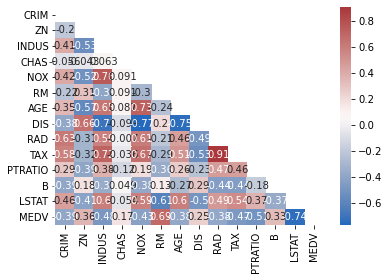

In [6]:
corr=boston.corr()
mask = np.zeros_like(boston.corr())
mask[np.triu_indices_from(mask)] = True
correlation_matrix=boston.corr().round(3)
sns.heatmap(data=correlation_matrix, annot=True, mask=mask, cmap="vlag")

Here we have the full correlation matrix for the dataset, but we will segment it by the strength of association to reason about the relationship between variables.

<AxesSubplot:>

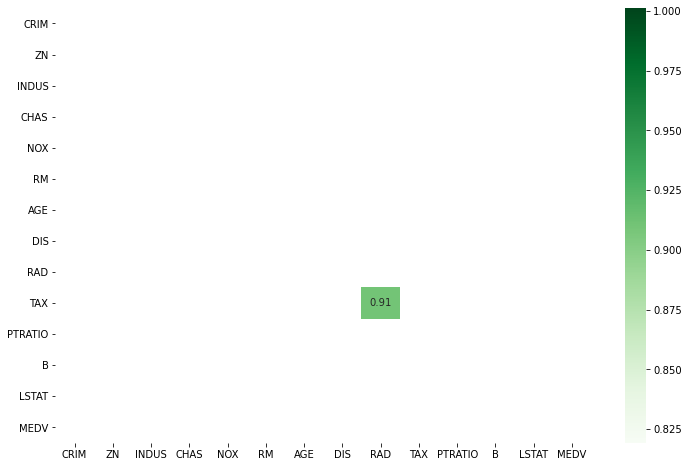

In [7]:
high = (corr[(abs(corr) >=.9) & (corr<1)])
plt.figure(figsize=(12,8))
sns.heatmap(high, cmap="Greens", annot=True, mask=mask)

The highest correlation is between RAD and TAX, indicating that though one may be used in the model, using both would be innappropriate. Let us examine thier scatterplot as well as its correlation with Median Value.

In [8]:
print(f"The correlation of RAD with MEDV: {round(pearsonr(boston['RAD'],boston['MEDV'])[0],3)}")
print(f"The correlation of TAX with MEDV: {round(pearsonr(boston['TAX'],boston['MEDV'])[0],3)}")

The correlation of RAD with MEDV: -0.382
The correlation of TAX with MEDV: -0.469


We observe that the magnitude of the correaltion between the median home value with full value property tax is greater than that of its correlation with access to radial highways. This indicates that it is likely that TAX has greater predictive power than RAD and that if we are to use either of them, it would be TAX.

<AxesSubplot:>

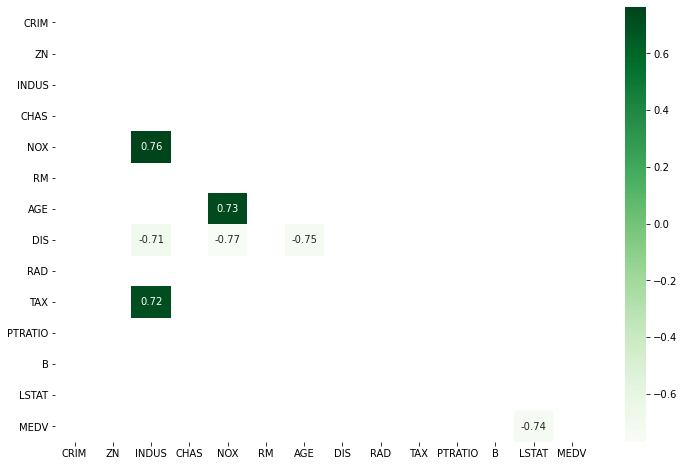

In [9]:
mod_high = (corr[(abs(corr) >= .7) & (abs(corr) < .9)])
plt.figure(figsize=(12,8))
sns.heatmap(mod_high, cmap="Greens", annot=True, mask=mask)

Here MEDV's correlation with LSTAT is of particular interest, as its absolute value is around .75, which is ideal for predictive features. 

<AxesSubplot:>

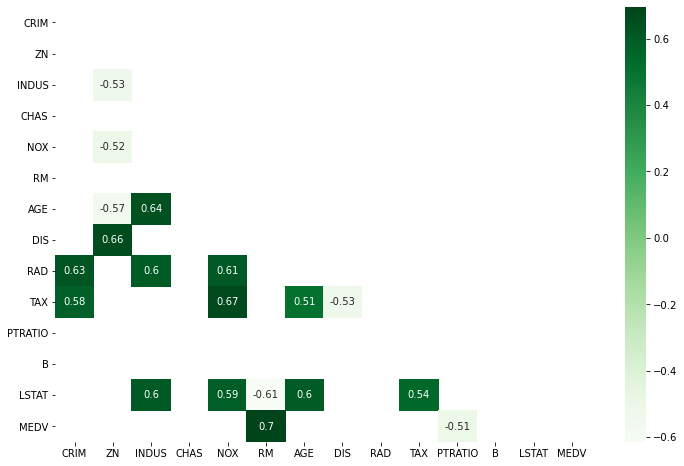

In [10]:
med = (corr[(abs(corr) >= .5) & (abs(corr) < .7)])
plt.figure(figsize=(12,8))
sns.heatmap(med, cmap="Greens", annot=True, mask=mask)

Similarly, the correlations between MEDV and RM are quite high making it another likely candidate for our predictive model. Between RM and LSTAT, the absolute value of the highest correlation amongst the other explanatory variable is around .6, indicating that they not only correlated with the response, but adequtely linearly independent from the other features. PTRatio shares these promising characteristics, but to a lesser degree, warranting its possible inclusion in the a predictive model.

<AxesSubplot:>

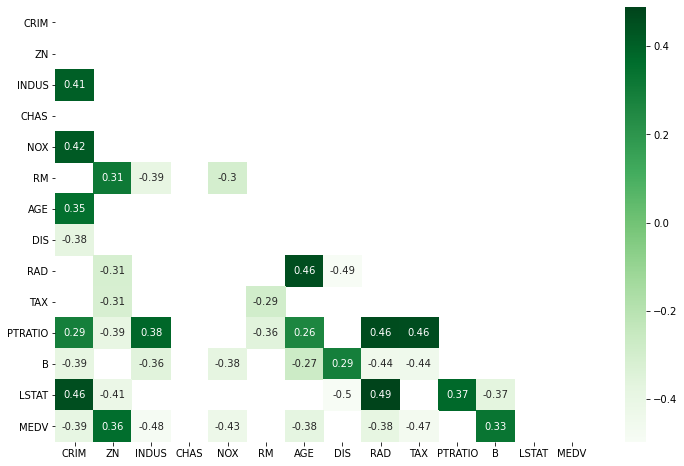

In [11]:
mod_low = (corr[(abs(corr) >= .25) & (abs(corr) <.5)])
plt.figure(figsize=(12,8))
sns.heatmap(mod_low, cmap="Greens", annot=True, mask=mask)

<AxesSubplot:>

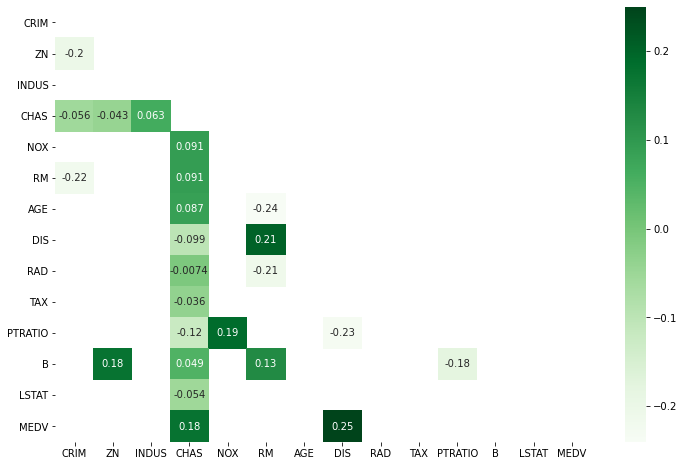

In [12]:
low = (corr[(abs(corr) >= 0) & (abs(corr) < .25)])
plt.figure(figsize=(12,8))
sns.heatmap(low, cmap="Greens", annot=True, mask=mask)


I present the lowest correlations for completeness.

## Linearity

In this section we assess the the relationship between our predcitors and response with respect to linearity, which we investigate this property for the predictors indicated in the aforementioned sections, namely, LSTAT, PTRATIO and RM.

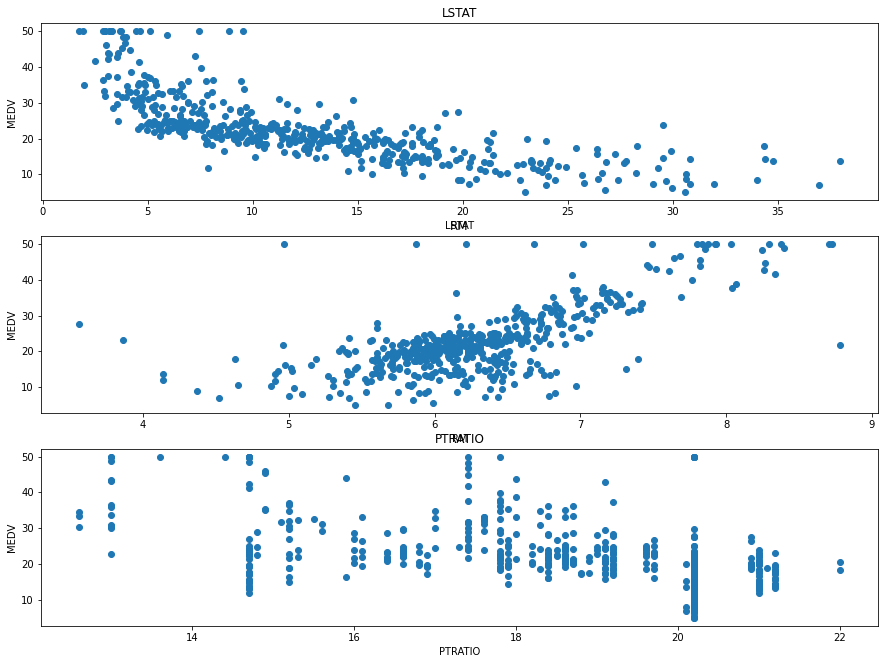

In [13]:
features=["LSTAT", "RM", "PTRATIO"]
target=boston["MEDV"]
plt.figure(figsize=(15,15))
for i, col in enumerate(features):
    plt.subplot(4, len(features)/2, i+1)
    x=boston[col]
    y=target
    plt.scatter(boston[col],y,marker="o")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("MEDV")

The relationship between LSTAT and MEDV appears to be somewhat curvilinear, while RM and PTRATIO seem to suffer from moderate to sever heteroskedaskicity, respectively. 

## Linear Model

In [14]:
X=pd.DataFrame(np.c_[boston["RM"], boston["PTRATIO"], boston["LSTAT"].apply(np.log)], columns=["RM", "PTRATIO","LSTAT^2"])
Y = y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 3)
(102, 3)
(404,)
(102,)


In [15]:
lin_model=LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

## Model Evaluation

### Training Set

In [16]:
# model evaluation for training set
y_train_predict=lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2=r2_score(Y_train, y_train_predict)

In [17]:
print("The model performance on training set")
print("-------------------------------------")
print(f"RMSE is {rmse}\nR2 score is {r2}\n")

The model performance on training set
-------------------------------------
RMSE is 4.843019148502801
R2 score is 0.7269572646730218



### Test Set

In [18]:
# model evaluation for test set
y_test_predict = lin_model.predict(X_test)
rmse=(np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

In [19]:
print("The model performance on training set")
print("-------------------------------------")
print(f"RMSE is {rmse}\nR2 score is {r2}\n")

The model performance on training set
-------------------------------------
RMSE is 4.395447699110677
R2 score is 0.753237887010362

